In [1]:
## LOAD MODULES ##
# Third Party
import sys
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num
import xarray as xr
from matplotlib import cm
import datetime as dt
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray
import pickle
from matplotlib.lines import Line2D
pd.plotting.deregister_matplotlib_converters()

# First Party
sys.path.append('../utilities_tlezuo/')
# from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import get_stations_timeseries as gs

###############################################################################################
# define class of pc_dict
class Point_coordinates:
    def __init__(self, shortname, name, color, marker, lat, lon, altitude, iconID, iconHSURF, iconHHL, iconHFL, height_dict):
        self.short = shortname
        self.name = name
        self.color = color
        self.marker = marker
        self.lat = lat
        self.lon = lon
        self.alt = altitude
        self.iconID = iconID 
        self.iconHSURF = iconHSURF
        self.iconHHL = iconHHL
        self.iconHFL = iconHFL
        self.hdict = height_dict 


# load pc_dict and its lists
pc_dict = np.load('../utilities_tlezuo/pc_dict.npy',allow_pickle=True).item()

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
###############################################################################################
## DECIDE WHAT TO LOAD ##
# variables
spvar = vf.P
spvars_list=[spvar,]

# locations
pc_short_list_plot = ['LAN', 'IMS', 'HAI', 'UNI', 'RIN', 'kols', 'egg', 'hoch',  'terf', 'weer', 'arb','ALP', 'KUF', 'MUC']
# type of icon data: std, hf, int
icon_type = 'std' 

# time range
startdate_plot = dt.datetime(2019,9,12,12,00)
enddate_plot = dt.datetime(2019,9,14,0,00)
plotfreq_plot = '2h0min'
plotdates_plot = pd.date_range(startdate_plot,enddate_plot,freq=plotfreq_plot)

LAN
IMS
HAI
UNI
RIN
kols
5 files found for this station
found P as pact in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Kolsass_RAW_58a00cfd/data.csv
Index(['columns: P', 'columns: timestamp'], dtype='object')
egg
2 files found for this station
found P as p_avg in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Eggen_RAW_319e6a8c/data.csv
Index(['columns: P', 'columns: timestamp'], dtype='object')
hoch
3 files found for this station
found P as p in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_FLUXL12_1f7675db/data.csv
found P as p in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Hochhaueser_S2017_cf922acc/data.csv
Index(['columns: P', 'columns: timestamp'], dtype='object')
terf
2 files found for this station
found P as pact in /users/tlezuo/data/stations/ACINNiBox/acinn_data_i-Box Terfens_RAW_ed06922e/data.csv
Index(['columns: P', 'columns: timestamp'], dtype='object')
weer
3 files found for this station
found P as p_avg in /users/tlezuo/

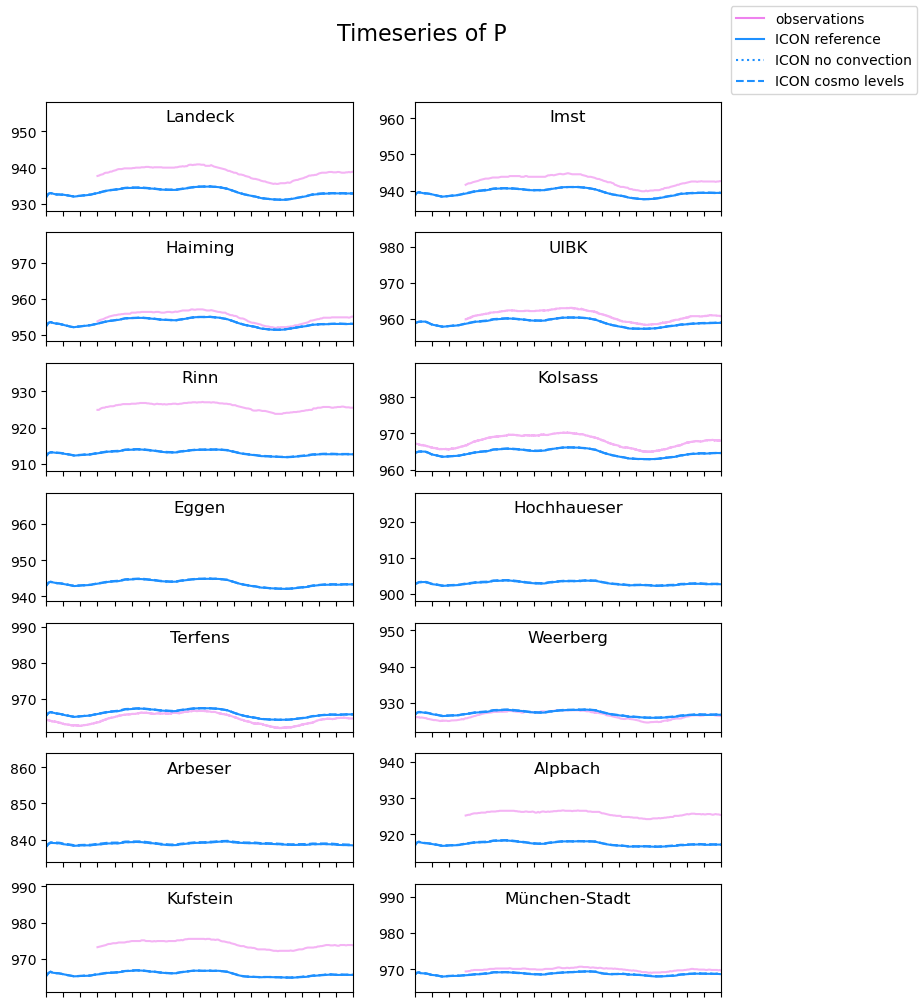

In [3]:
# figure settings
fig, ax = plt.subplots(7,2, figsize=(10,10))
plt.subplots_adjust(bottom=0.01, right=0.8, top=0.9,hspace=0.2,wspace=0.2)
fig.suptitle('Timeseries of '+spvar.name, fontsize=16)
for ax_ts,plotstation in zip(ax.flatten(),pc_short_list_plot):
        loc = pc_dict[plotstation]
        print(plotstation)

        # get metadata on station
        if plotstation in ['LAN', 'IMS', 'HAI','RIN','ALP', 'KUF']:
                stat_type = 'toni' 
                provider = 'zamg'   
        elif plotstation in ['UNI']:
                stat_type = 'toni' 
                provider = 'acinn'   
        elif plotstation in ['KUF', 'MUC']:
                stat_type = 'toni' 
                provider = 'dwd'   
        else:
                stat_type = 'ibox' 
                provider = ' '  
        ## LOAD DATA STATION ##
        if stat_type == 'ibox':
                ts_data_stat = gs.read_acinn(loc=loc, 
                                        vars=spvars_list,
                                        path_ACINN= '/users/tlezuo/data/stations/ACINNiBox',
                                        start_time = dt.datetime(2019,9,12,12,00).strftime("%Y-%m-%d %H:%M:%S"),
                                        end_time = dt.datetime(2019,9,14,00,00).strftime("%Y-%m-%d %H:%M:%S"),
                                        correct_direction=True)
                ts_data_stat['dt'] = pd.to_datetime(ts_data_stat["timestamp"])
        else:
                ts_data_stat = np.load('/users/tlezuo/toni_codes/PLOTS/ts_stationdata.npy',allow_pickle='TRUE').item()
                ts_data_stat = ts_data_stat [loc.short]

        ## LOAD DATA ICON TS ##
        if icon_type == 'std':# standard (15min)
                #run2
                ts_data_icon_RUN2 = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_std/std_htd_data_RUN2_reference.nc')
                ts_data_icon_RUN2 = ts_data_icon_RUN2.sel(ncells=loc.subsetID,height=81,height_3=80,height_4=81)
                #run3
                ts_data_icon_RUN3 = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_std/std_htd_data_RUN3_noconv.nc')
                ts_data_icon_RUN3 = ts_data_icon_RUN3.sel(ncells=loc.subsetID,height=81,height_3=80,height_4=81)
                #run4
                ts_data_icon_RUN4 = xarray.open_mfdataset('/users/tlezuo/icon-vis/data/data_std/std_htd_data_RUN4_cosmolev.nc')
                ts_data_icon_RUN4 = ts_data_icon_RUN4.sel(ncells=loc.subsetID,height=81,height_3=80,height_4=81)
        elif icon_type == 'hf': # high frequency (10s)
                #run2
                ts_data_icon_RUN2 = xr.open_dataset('/users/tlezuo/icon-vis/data/data_hfsu/hfsu_ts_data_RUN2_reference.nc')
                ts_data_icon_RUN2 = ts_data_icon_RUN2.sel(ncells=loc.subsetID)
                #run3
                ts_data_icon_RUN3 = xr.open_dataset('/users/tlezuo/icon-vis/data/data_hfsu/hfsu_ts_data_RUN3_noconv.nc')
                ts_data_icon_RUN3 = ts_data_icon_RUN3.sel(ncells=loc.subsetID)
                #run4
                ts_data_icon_RUN4 = xr.open_dataset('/users/tlezuo/icon-vis/data/data_hfsu/hfsu_ts_data_RUN4_cosmolev.nc')
                ts_data_icon_RUN4 = ts_data_icon_RUN4.sel(ncells=loc.subsetID)

        for ts_data_icon in [ts_data_icon_RUN2,ts_data_icon_RUN3,ts_data_icon_RUN4]:
                ts_data_icon['VEL_10M'] = ts_data_icon['VEL_10m'] 
                ts_data_icon['DIR_10M'] = ts_data_icon['DIR_10m'] 
                ts_data_icon['T'] =     ts_data_icon['T'] -273.15

        # rename columns
        if stat_type == 'toni':
                if provider == 'zamg':
                        ts_data_stat['dt']=ts_data_stat.index
                        ts_data_stat['VEL_10M']=ts_data_stat['FF']
                        ts_data_stat['DIR_10M']=ts_data_stat['DD']
                        ts_data_stat['T_2M']=ts_data_stat['TL']
                if provider == 'acinn':
                        ts_data_stat['dt']=ts_data_stat.index
                        ts_data_stat['VEL_10M']=ts_data_stat['ws_ms']
                        ts_data_stat['P']=ts_data_stat['p_hPa']
                        ts_data_stat['DIR_10M']=ts_data_stat['wd_deg']
                        ts_data_stat['T_2M']=ts_data_stat['t_K']
                if provider == 'dwd':
                        ts_data_stat['dt']=ts_data_stat.index
                        ts_data_stat['VEL_10M']=ts_data_stat['FF_10']
                        ts_data_stat['P']=ts_data_stat['PP_10']
                        ts_data_stat['DIR_10M']=ts_data_stat['DD_10']
                        ts_data_stat['T_2M']=ts_data_stat['TT_10']
        else:
                ts_data_stat=ts_data_stat

        # OBS
        handle_obs = Line2D([0], [0], color='violet',linestyle='solid')
        ax_ts.plot(ts_data_stat['dt'],np.transpose(ts_data_stat[spvar.name]),color='violet',alpha=0.6, label='observations')

        # ICON 
        # ax_ts.plot(plotdates_model,ts_data_icon[spvar.name],color='dodgerblue',label='ICON')
        plotdates_model = pd.date_range(startdate_plot,enddate_plot,freq='1h')
        # plotdates_model = ts_data_icon_RUN2.time
        handle_I2 = Line2D([0], [0], color='dodgerblue',linestyle='solid')
        handle_I3 = Line2D([0], [0], color='dodgerblue',linestyle='dotted')
        handle_I4 = Line2D([0], [0], color='dodgerblue',linestyle='dashed')
        # ax_ts.plot(ts_data_icon_RUN1.time,ts_data_icon_RUN1.TKE,color='gray',label='ICON old')
        if icon_type == 'std' and spvar.name == 'T_2M':
                ax_ts.plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2['T'],color='dodgerblue',label='ICON reference')
                ax_ts.plot(ts_data_icon_RUN3.time,ts_data_icon_RUN3['T'],color='dodgerblue',linestyle = 'dotted', label='ICON no convection')
                ax_ts.plot(ts_data_icon_RUN4.time,ts_data_icon_RUN4['T'],color='dodgerblue',linestyle = 'dashed',label='ICON cosmo levels')
        else:
                ax_ts.plot(ts_data_icon_RUN2.time,ts_data_icon_RUN2[spvar.name],color='dodgerblue',label='ICON reference')
                ax_ts.plot(ts_data_icon_RUN3.time,ts_data_icon_RUN3[spvar.name],color='dodgerblue',linestyle = 'dotted', label='ICON no convection')
                ax_ts.plot(ts_data_icon_RUN4.time,ts_data_icon_RUN4[spvar.name],color='dodgerblue',linestyle = 'dashed',label='ICON cosmo levels')

        # plotting options
        if spvar.name == 'P':
                ax_ts.set_ylim(np.mean(ts_data_icon_RUN2.P)-5,np.mean(ts_data_icon_RUN2.P)+25)
        else:
                ax_ts.set_ylim(spvar.min,spvar.max)
        ax_ts.set_xlim(startdate_plot,enddate_plot)
        # ax_ts.grid()
        ax_ts.set_title(loc.name, y=1.0, pad=-14)
        # ax_ts.set_xlabel('Time [h]')
        ax_ts.set_xticks(plotdates_plot)
        ax_ts.set_xticklabels([])
        # ax_ts.set_ylabel(spvar.name+' '+spvar.units)
        # fig.legend(labels=('observations','ICON'),loc=(0.75,0.935))
        # ax_ts.annotate('(obs at '+str(loc.hdict[spvar.name])+' m AGL)', xy=(0.40,0.92),xytext=(0.39,0.92),xycoords=('axes fraction','axes fraction'),color='violet')

        ##################################################################################################
        # ## DIR if VEL is plotted ##
        # if spvar.name == 'VEL_10M':
        #         # plot
        #         ax_ts_2 = ax_ts.twinx()
        #         ax_ts_2.scatter(ts_data_stat['dt'],np.transpose(ts_data_stat['DIR_10M']),color='violet',alpha=0.4,s=4) # station obs
        #         # model
        #         ax_ts_2.scatter(ts_data_icon_RUN2.time,ts_data_icon_RUN2['DIR_10M'],color='dodgerblue',alpha=0.4,s=2)
        #         ax_ts_2.scatter(ts_data_icon_RUN3.time,ts_data_icon_RUN3['DIR_10M'],color='dodgerblue',alpha=0.4,s=2)
        #         ax_ts_2.scatter(ts_data_icon_RUN4.time,ts_data_icon_RUN4['DIR_10M'],color='dodgerblue',alpha=0.4,s=2)

        #         # plotting options
        #         ax_ts_2.set_ylim(-20,380)
        #         ax_ts_2.set_yticks(np.arange(0,365,90))
        #         # ax_ts_2.set_ylabel('DIR_10M [°]')
        #         ax_ts_2.set_xlim(startdate_plot,enddate_plot)
        #         ax_ts.set_xticklabels([])
        #         ax_ts_2.set_xticks(plotdates_plot)
        #         # ax_ts_2.set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])

legend_handles=[handle_obs,handle_I2,handle_I3, handle_I4]
legend_labels=['observations','ICON reference','ICON no convection','ICON cosmo levels']
fig.legend(legend_handles,legend_labels)
# ax[:,-1].set_xticklabels(labels=[j.strftime('%H') for j in plotdates_plot])
# ax[:,-1].set_xlabel('Time [h]')

In [4]:
spvar.name

'P'